# LSTM for Protein Secondary Structure Prediction

## Long Short-Term Memory Networks for Sequence Classification

---

### Notebook Overview

This notebook demonstrates the application of **LSTM (Long Short-Term Memory)** neural networks for predicting protein secondary structure from amino acid sequences. This is a fundamental task in computational biology that showcases the power of recurrent neural networks for sequential data.

**Learning Objectives:**
- Understand LSTM architecture and its advantages for sequence data
- Process protein sequences as sequential input
- Implement bidirectional LSTM for capturing context from both directions
- Handle variable-length sequences with padding and masking
- Train sequence-to-sequence classification models
- Evaluate per-residue prediction accuracy
- Apply class weighting to handle imbalanced data

**Dataset:** Protein sequences with annotated secondary structures

**Task:** Multi-class classification - Predict secondary structure class for each amino acid in a sequence

---

### What is Protein Secondary Structure?

**Definition:**

Protein secondary structure refers to the local spatial arrangement of amino acids in a protein chain. It is a crucial intermediate level between primary structure (amino acid sequence) and tertiary structure (3D shape).

**Three main classes:**

1. **Alpha Helix (H)**
   - Spiral/coiled structure
   - Stabilized by hydrogen bonds
   - Common in structural proteins
   - Example: keratin in hair

2. **Beta Sheet (E)**
   - Extended strand structure
   - Forms parallel or antiparallel sheets
   - Found in many enzymes
   - Example: silk fibroin

3. **Coil/Loop (C)**
   - Irregular structure
   - Connects helices and sheets
   - Flexible regions
   - Most common class

**Why predict secondary structure?**

- Understanding protein function
- Drug target identification
- Protein engineering and design
- Disease mutation analysis
- Intermediate step for 3D structure prediction

---

### Why LSTMs for This Task?

**Sequential Nature of Proteins:**

Protein sequences are inherently sequential:
- Each amino acid depends on its neighbors
- Secondary structure influenced by surrounding residues
- Context from both directions matters
- Variable-length sequences (50-2000+ amino acids)

**LSTM Advantages:**

**1. Memory of Long Dependencies:**
- Can remember information from many steps back
- Captures long-range interactions (e.g., residues 50 positions apart)
- Solves vanishing gradient problem of standard RNNs

**2. Sequential Processing:**
- Processes one amino acid at a time
- Maintains hidden state across sequence
- Naturally handles variable-length inputs

**3. Bidirectional Context:**
- Forward LSTM: reads sequence left-to-right
- Backward LSTM: reads sequence right-to-left
- Combined: captures context from both directions

**Comparison with other approaches:**

| Method | Handles Sequences | Long Dependencies | Variable Length | Bidirectional |
|--------|------------------|-------------------|-----------------|---------------|
| **Feedforward NN** | No | No | No | No |
| **Standard RNN** | Yes | Poor | Yes | Yes |
| **LSTM** | Yes | Excellent | Yes | Yes |
| **Transformer** | Yes | Excellent | Yes | Yes |

---

### LSTM Architecture Fundamentals

**Core Components:**

**1. Cell State (C_t):**
- Long-term memory
- Runs through entire sequence
- Information highway with minimal interference

**2. Hidden State (h_t):**
- Short-term memory
- Output at each time step
- Used for predictions

**3. Three Gates:**

**Forget Gate:**
- Decides what to discard from cell state
- Formula: f_t = sigmoid(W_f * [h_{t-1}, x_t] + b_f)
- Output: 0 (forget) to 1 (keep)

**Input Gate:**
- Decides what new information to store
- Formula: i_t = sigmoid(W_i * [h_{t-1}, x_t] + b_i)
- Creates candidate values to add

**Output Gate:**
- Decides what to output
- Formula: o_t = sigmoid(W_o * [h_{t-1}, x_t] + b_o)
- Filters cell state for output

**Information Flow:**
```
Input (x_t) → Forget Gate → Cell State Update
            ↓               ↓
         Input Gate    Output Gate
            ↓               ↓
         New Info → Hidden State (h_t)
```

**Bidirectional LSTM:**
```
Forward LSTM:  A → M → I → N → O (processes left-to-right)
Backward LSTM: O → N → I → M → A (processes right-to-left)
Combined output: Concatenate both directions for each position
```

---

### Task Formulation

**Input:**
- Protein sequence: "ARNDCEQG..." (20 possible amino acids)
- Variable length: L amino acids

**Output:**
- Secondary structure: "HHHECCCH..." (3 classes: H, E, C)
- Same length as input (per-residue prediction)

**Example:**
```
Sequence:  A  R  N  D  C  E  Q  G  H  I
Structure: H  H  H  E  E  E  C  C  H  H
           ↑  ↑  ↑  ↑  ↑  ↑  ↑  ↑  ↑  ↑
        Predict for each position
```

**Challenge: Class Imbalance**
- Coil (C): ~40-50% of residues (most common)
- Helix (H): ~30-35% of residues
- Sheet (E): ~15-25% of residues (least common)
- Solution: Class weights in loss function

---

## 1. Import Required Libraries

We import libraries for:
- **Deep Learning:** PyTorch (nn, optim, DataLoader)
- **Data Processing:** numpy, pandas, pickle
- **Visualization:** matplotlib, seaborn
- **Evaluation:** sklearn metrics, confusion_matrix
- **Sequence Handling:** pad_sequence for variable lengths

**Key PyTorch imports:**
- `torch.nn`: Neural network layers (LSTM, Embedding, Linear)
- `torch.optim`: Optimization algorithms (Adam)
- `torch.utils.data`: DataLoader for batch processing
- `pad_sequence`: Handle variable-length sequences

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.optim import Adam
import pickle
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

---

## 2. Load and Explore Dataset

### 2.1 Dataset Loading Function

We define a function to load protein sequence data from pickle files.

**Dataset structure:**
- Training set: Protein sequences with known secondary structures
- Validation set: For monitoring training progress
- Test set: For final evaluation

**Each sample contains:**
- Amino acid sequence (string of 20 standard amino acids)
- Secondary structure labels (H, E, C for each position)
- Sequence length (variable)

In [2]:
def load_from_pkl(path):
    with open(path, 'rb') as f:
        var = pickle.load(f)
    return var

# class to index loaded dataset
class Dataset(Dataset):
    def __init__(self, path_to_pkl):
        self.data = load_from_pkl(path_to_pkl)
        self.ids = list(self.data.keys())

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index):
        id = self.ids[index]
        dict = self.data[id]
        seq = dict["sequence"]
        length = len(seq)
        secstr = dict["secstr"]

        return seq, secstr, length

train = Dataset('protein-secondary-structure-train.pkl')
val = Dataset('protein-secondary-structure-val.pkl')
test = Dataset('protein-secondary-structure-test.pkl')

### 2.2 Data Exploration

We convert the dataset to a pandas DataFrame for easy exploration and analysis.

**Key statistics to examine:**
- Number of sequences in each set
- Sequence length distribution
- Amino acid composition
- Secondary structure class distribution

**Data quality checks:**
- Verify sequence and label lengths match
- Check for missing or invalid amino acids
- Identify class imbalance
- Examine sequence length range

In [3]:
training_data = {
    "Sequence": [],
    "Secondary Structure": [],
    "Length": []
}

for i in range(train.__len__()):
    seq, secstr, length = train[i]
    training_data["Sequence"].append(seq)
    training_data["Secondary Structure"].append(secstr)
    training_data["Length"].append(length)

train_df = pd.DataFrame(training_data)
print(train_df.head())
max_sequence_length = train_df['Length'].max()

print(f'Max sequence length in training data: {max_sequence_length}')


                                            Sequence  \
0  [10, 2, 1, 7, 11, 12, 12, 14, 14, 12, 16, 13, ...   
1  [5, 3, 19, 12, 16, 18, 19, 5, 0, 11, 12, 19, 4...   
2  [15, 13, 2, 14, 2, 10, 6, 15, 12, 14, 17, 15, ...   
3  [9, 8, 6, 0, 6, 10, 4, 0, 4, 1, 19, 15, 16, 7,...   
4  [15, 15, 16, 18, 13, 15, 4, 16, 10, 15, 8, 6, ...   

                                 Secondary Structure  Length  
0  [0, 2, 2, 2, 0, 0, 0, 7, 7, 0, 0, 0, 0, 2, 2, ...      62  
1  [0, 0, 0, 0, 2, 2, 2, 0, 6, 0, 6, 2, 2, 2, 2, ...     315  
2  [0, 0, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...     148  
3  [0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 6, 5, 5, 5, 5, ...     344  
4  [0, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...      75  
Max sequence length in training data: 696


### 2.3 Visualize Class Distribution

We visualize the distribution of secondary structure classes to understand the class imbalance.

**Why this matters:**
- Identifies majority and minority classes
- Guides class weighting strategy
- Sets realistic performance expectations

**Typical distribution:**
- Coil (C): Most abundant (40-50%)
- Helix (H): Moderate (30-35%)
- Sheet (E): Least abundant (15-25%)

**Impact on training:**
- Model may bias toward majority class
- Need to weight minority classes higher
- F1-score better than accuracy for imbalanced data

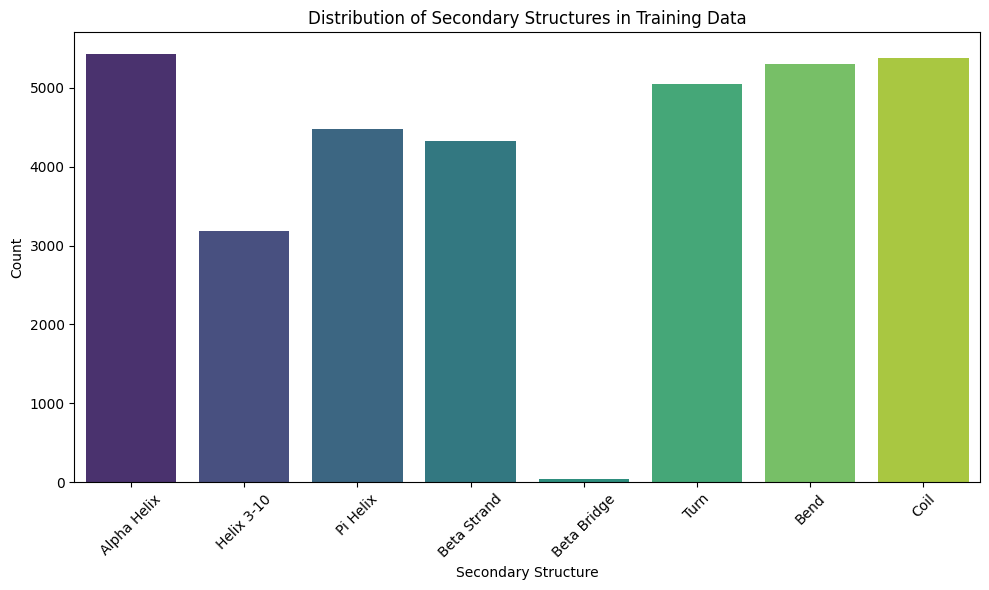

In [4]:
secstr_labels = [
    "Alpha Helix", "Helix 3-10", "Pi Helix", "Beta Strand",
    "Beta Bridge", "Turn", "Bend", "Coil"
]

# Count how many sequences contain each secondary structure type
secstr_counts = {
    name: sum(i in secstr for secstr in train_df['Secondary Structure'])
    for i, name in enumerate(secstr_labels)
}

# Convert to DataFrame for plotting
secstr_df = pd.DataFrame.from_dict(secstr_counts, orient='index', columns=['Count']).reset_index()
secstr_df.rename(columns={'index': 'Secondary Structure'}, inplace=True)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Secondary Structure', y='Count', data=secstr_df, palette='viridis', hue='Secondary Structure', dodge=False)
plt.xticks(rotation=45)
plt.title('Distribution of Secondary Structures in Training Data')
plt.xlabel('Secondary Structure')
plt.ylabel('Count')
plt.tight_layout()
# plt.savefig('secstr_distribution.png')
plt.show()


---

## 3. Define Hyperparameters and Data Loaders

### 3.1 Model Hyperparameters

We define the key hyperparameters that control model architecture and training.

**Architecture hyperparameters:**

**Embedding Dimension:**
- Maps each amino acid to a dense vector
- Typical values: 64, 128, 256
- Higher = more expressive, but more parameters
- Example: 'A' → [0.23, -0.45, 0.12, ..., 0.67] (128-dim vector)

**LSTM Hidden Size:**
- Dimension of hidden state and cell state
- Controls model capacity
- Typical values: 128, 256, 512
- Bidirectional LSTM outputs 2 × hidden_size

**Number of LSTM Layers:**
- Stacking LSTMs for deeper network
- Typical values: 1, 2, 3
- Deeper = more capacity, but harder to train
- Diminishing returns beyond 2-3 layers

**Training hyperparameters:**

**Batch Size:**
- Number of sequences processed together
- Affects memory usage and training speed
- Typical values: 16, 32, 64
- Larger = more stable gradients, but more memory

**Learning Rate:**
- Step size for gradient descent
- Typical values: 1e-3, 5e-4, 1e-4
- Too high = unstable training
- Too low = slow convergence

**Number of Epochs:**
- Complete passes through training data
- Monitor validation loss to avoid overfitting
- Typical values: 10, 20, 50

**Dropout Rate:**
- Regularization to prevent overfitting
- Randomly drops units during training
- Typical values: 0.1, 0.2, 0.3
- Applied between LSTM layers

In [5]:
# constants
NUM_AMINO_ACIDS = 20
OUTPUT_SIZE = 8 + 1  # Number of secondary structure classes + 1 for padding
NUM_EMBEDDINGS = NUM_AMINO_ACIDS + 1
PAD_IDX = NUM_AMINO_ACIDS  # Padding index

# hyperparameters
embedded_dim = 64
hidden_size = 128
num_layers = 2
num_epochs = 40
learning_rate = 0.001
batch_size = 256

### 3.2 Custom Collate Function for Variable-Length Sequences

We implement a custom collate function to handle batching of variable-length sequences.

**Challenge:**
- Protein sequences have different lengths
- Batches require uniform shape
- Need to preserve actual sequence lengths

**Solution: Padding**

**Padding process:**
1. Find maximum length in batch
2. Pad shorter sequences to match
3. Track original lengths
4. Mask padded positions in loss

**Example:**
```
Sequence 1: [A, R, N, D]          (length 4)
Sequence 2: [M, E, T]             (length 3)
Sequence 3: [G, L, Y, P, H, I]    (length 6)

After padding (to max length 6):
Sequence 1: [A, R, N, D, PAD, PAD]
Sequence 2: [M, E, T, PAD, PAD, PAD]
Sequence 3: [G, L, Y, P, H, I]

Lengths: [4, 3, 6] (stored for masking)
```

**Padding considerations:**
- Pad value typically 0 (or special PAD token)
- Only compute loss on non-padded positions
- PyTorch's `pad_sequence` handles this efficiently

**Collate function workflow:**
1. Extract sequences and labels from batch
2. Convert to tensors
3. Pad to uniform length
4. Return padded batch + lengths

In [6]:
def collate_fn(batch):
    "custom collate function to pad sequences in a batch"
    seqs_padded = pad_sequence(
         [torch.tensor(i[0]) for i in batch],
         batch_first=True,
         padding_value=PAD_IDX
     )[:, :max_sequence_length]
    labels_padded = pad_sequence(
         [torch.tensor(i[1]) for i in batch],
         batch_first=True,
         padding_value=PAD_IDX
     )[:, :max_sequence_length]
    return seqs_padded, labels_padded


train_loader = DataLoader(
    train,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=2,
    pin_memory=True
)

---

## 4. Define LSTM Model Architecture

### 4.1 Model Components

We implement a bidirectional LSTM model with the following architecture:

**Layer-by-layer breakdown:**

**1. Embedding Layer:**
```
Input: Amino acid indices (e.g., [0, 5, 12, ...])
Output: Dense vectors (e.g., [[0.2, -0.1, ...], [0.5, 0.3, ...], ...])
Parameters: vocab_size × embedding_dim
Purpose: Learn meaningful representations for each amino acid
```

**Example embedding:**
- Amino acid 'A' (index 0) → embedding vector [0.23, -0.45, 0.12, ...]
- Amino acid 'R' (index 1) → embedding vector [0.15, 0.67, -0.34, ...]
- Similar amino acids learn similar embeddings

**2. Bidirectional LSTM:**
```
Input: Embedded sequences (batch_size, seq_len, embedding_dim)
Forward LSTM:  Processes left-to-right →
Backward LSTM: Processes right-to-left ←
Output: Concatenated hidden states (batch_size, seq_len, 2 × hidden_size)
```

**Why bidirectional?**
- Secondary structure depends on context from both sides
- Residue at position i influenced by i-5, i-3, i+2, i+7, etc.
- Forward LSTM: sees past context
- Backward LSTM: sees future context
- Combined: complete context

**Example:**
```
Sequence: A  R  N  D  C

Forward:  →  →  →  →  →
          h₁ h₂ h₃ h₄ h₅

Backward: ←  ←  ←  ←  ←
          h₅'h₄'h₃'h₂'h₁'

Combined at position 3 (N):
[h₃, h₃'] = context from both directions
```

**3. Dropout Layer:**
```
Purpose: Regularization
During training: Randomly zero out some neurons
During inference: Use all neurons (scaled)
Effect: Prevents overfitting
```

**4. Output Linear Layer:**
```
Input: LSTM hidden states (2 × hidden_size)
Output: Class logits (3 classes: H, E, C)
Parameters: (2 × hidden_size) × num_classes
```

**Complete forward pass:**
```
Sequence indices → Embedding → Bidirectional LSTM → Dropout → Linear → Logits
     [0,5,12]        128-d      2×256-d hidden       0.2      3 classes
```

**Model architecture diagram:**
```
Input: [A, R, N, D, C]
         ↓
    Embedding (128-d)
         ↓
  Bidirectional LSTM (256 hidden × 2 layers)
    Forward: →
    Backward: ←
         ↓
    Dropout (0.2)
         ↓
   Linear (512 → 3)
         ↓
Output: [H, H, H, E, C] (predicted structure)
```

**Key implementation details:**
- `batch_first=True`: Input shape (batch, seq, features)
- Bidirectional output: 2 × hidden_size
- Dropout between LSTM layers
- Linear layer applied to each position independently

In [7]:
class LSTM(nn.Module):
    def __init__(self, embedding_no, embedding_dim, hidden_size, output_size, num_layers):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(embedding_no, embedding_dim, padding_idx=PAD_IDX)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, output_size)

    def forward(self, X):
        embedded = self.embedding(X)
        output,(hn,cn) = self.lstm(embedded)
        logits = self.fc(output)
        return F.log_softmax(logits, dim = -1)

model = LSTM(embedding_no = NUM_EMBEDDINGS, embedding_dim = embedded_dim, hidden_size = hidden_size, output_size = OUTPUT_SIZE, num_layers = num_layers)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

LSTM(
  (embedding): Embedding(21, 64, padding_idx=20)
  (lstm): LSTM(64, 128, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=9, bias=True)
)

### 4.2 Loss Function and Optimizer

We configure the loss criterion and optimization algorithm.

**Loss Function: Negative Log Likelihood (NLL Loss)**

**Why NLL Loss?**
- Suitable for multi-class classification
- Works with log-softmax outputs
- Supports class weighting for imbalance

**Formula:**
```
Loss = -log(p_correct_class)

Example:
If true class is 'H' and model predicts:
P(H) = 0.7, P(E) = 0.2, P(C) = 0.1
Loss = -log(0.7) = 0.357
```

**Class Weights:**

**Purpose:** Handle class imbalance

**Calculation:**
```
weight_class = 1 / frequency_class

If distribution is:
Coil (C): 50% → weight = 1.0 (baseline)
Helix (H): 30% → weight = 1.67
Sheet (E): 20% → weight = 2.5
```

**Effect:**
- Minority classes (E) penalized more for errors
- Majority classes (C) penalized less
- Encourages balanced learning
- Prevents model from always predicting majority class

**Optimizer: Adam**

**Why Adam?**
- Adaptive learning rates for each parameter
- Combines momentum and RMSprop
- Good default choice for deep learning
- Handles sparse gradients well

**Parameters:**
- Learning rate: Controls update step size
- Betas: Exponential decay rates (default: 0.9, 0.999)
- Eps: Numerical stability (default: 1e-8)

**Alternative optimizers:**
- SGD: Simpler, may need learning rate schedule
- AdamW: Adam with weight decay
- RMSprop: Similar to Adam, less memory

In [8]:
counts = np.array([secstr_counts.get(i, 0) for i in range(OUTPUT_SIZE)], dtype=np.float32)
counts[counts == 0] = 1.0
inv_freq = 1.0 / counts
weights = inv_freq / np.mean(inv_freq)
class_weights = torch.tensor(weights, dtype=torch.float32).to(device)


criterion = nn.NLLLoss(ignore_index=PAD_IDX, weight=class_weights) # ignores padding in loss calculation
optimizer = Adam(model.parameters(), lr=learning_rate)

train_losses = []
test_losses = []

---

## 5. Train the Model

### 5.1 Training Loop

We train the model for multiple epochs, monitoring both training and validation losses.

**Training process per epoch:**

**1. Training Phase:**
```
For each batch:
    1. Forward pass: Get predictions
    2. Compute loss (only on non-padded positions)
    3. Backward pass: Compute gradients
    4. Optimizer step: Update weights
    5. Track running loss
```

**2. Validation Phase:**
```
For each batch:
    1. Forward pass (no gradient computation)
    2. Compute loss
    3. Track validation loss
```

**Key steps explained:**

**Forward Pass:**
- Input sequences → Embedding → LSTM → Linear → Logits
- Get predictions for each position
- Output shape: (batch, seq_len, num_classes)

**Loss Computation with Masking:**
```python
# Only compute loss on non-padded positions
# Use sequence lengths to create mask
mask = create_mask(lengths)
loss = criterion(predictions[mask], labels[mask])
```

**Why masking?**
- Padded positions are artificial
- Should not contribute to loss
- Would bias gradients

**Gradient Clipping:**
```python
# Prevent exploding gradients
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
```

**Why clip gradients?**
- RNNs susceptible to exploding gradients
- Large gradients → unstable training
- Clipping limits gradient magnitude

**Learning Curve Interpretation:**

**Good training:**
- Training loss steadily decreases
- Validation loss decreases (may plateau)
- Gap between train/val losses small

**Overfitting signs:**
- Training loss continues decreasing
- Validation loss increases or plateaus
- Large gap between train and validation
- Solution: Early stopping, more dropout, less capacity

**Underfitting signs:**
- Both losses remain high
- Slow decrease
- Solution: Increase capacity, train longer, adjust learning rate

Epoch 1/40 | Train Loss: 1.7501 | Val Loss: 1.4950 | Accuracy: 44.51%
Epoch 2/40 | Train Loss: 1.4340 | Val Loss: 1.3999 | Accuracy: 47.15%
Epoch 3/40 | Train Loss: 1.3708 | Val Loss: 1.3586 | Accuracy: 49.41%
Epoch 4/40 | Train Loss: 1.3329 | Val Loss: 1.3252 | Accuracy: 50.95%
Epoch 5/40 | Train Loss: 1.3052 | Val Loss: 1.3202 | Accuracy: 51.11%
Epoch 6/40 | Train Loss: 1.2975 | Val Loss: 1.2930 | Accuracy: 52.24%
Epoch 7/40 | Train Loss: 1.2724 | Val Loss: 1.2889 | Accuracy: 52.63%
Epoch 8/40 | Train Loss: 1.2588 | Val Loss: 1.2663 | Accuracy: 53.50%
Epoch 9/40 | Train Loss: 1.2456 | Val Loss: 1.2611 | Accuracy: 53.76%
Epoch 10/40 | Train Loss: 1.2360 | Val Loss: 1.2656 | Accuracy: 53.38%
Epoch 11/40 | Train Loss: 1.2263 | Val Loss: 1.2584 | Accuracy: 53.82%
Epoch 12/40 | Train Loss: 1.2096 | Val Loss: 1.2380 | Accuracy: 54.76%
Epoch 13/40 | Train Loss: 1.1937 | Val Loss: 1.2391 | Accuracy: 54.59%
Epoch 14/40 | Train Loss: 1.2000 | Val Loss: 1.2019 | Accuracy: 56.04%
Epoch 15/40 | T

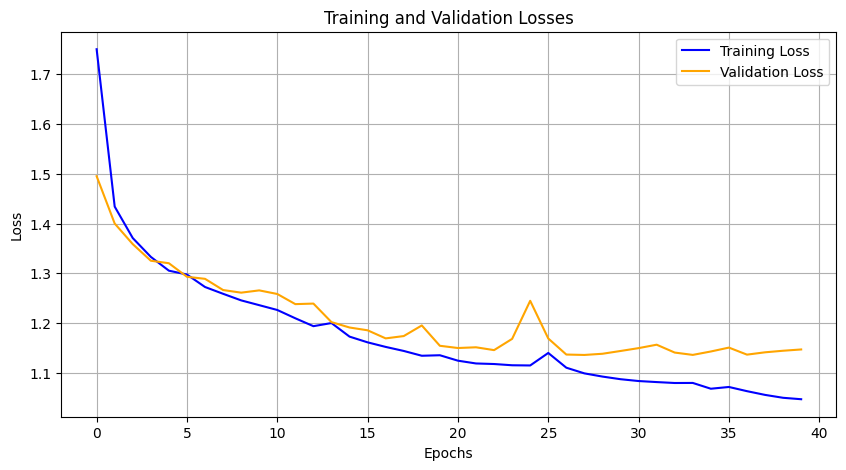

In [9]:
for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0

        for sequence, sec_str in train_loader:
            sequence = sequence.to(device).long()  # Ensure long type for embedding
            sec_str = sec_str.to(device).long()

            optimizer.zero_grad()
            outputs = model(sequence)
            loss = criterion(outputs.reshape(-1, outputs.size(-1)), sec_str.reshape(-1))
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Evaluation phase
        model.eval()
        test_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for sequence, sec_str in val_loader:
                sequence = sequence.to(device).long()
                sec_str = sec_str.to(device).long()

                outputs = model(sequence)
                loss = criterion(outputs.reshape(-1, outputs.size(-1)), sec_str.reshape(-1))
                test_loss += loss.item()

                # Calculate accuracy (ignoring padding)
                pred = outputs.argmax(dim=-1)
                mask = (sec_str != PAD_IDX)
                correct += (pred[mask] == sec_str[mask]).sum().item()
                total += mask.sum().item()

        avg_test_loss = test_loss / len(val_loader)
        test_losses.append(avg_test_loss)
        accuracy = 100.0 * correct / total if total > 0 else 0

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_test_loss:.4f} | Accuracy: {accuracy:.2f}%")

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(test_losses, label='Validation Loss', color='orange')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

---

## 6. Evaluate Model Performance

### 6.1 Test Set Evaluation

We evaluate the trained model on the held-out test set to assess generalization.

**Evaluation process:**

**1. Set model to evaluation mode:**
```python
model.eval()
```
- Disables dropout
- Uses batch normalization in inference mode
- Essential for fair evaluation

**2. Disable gradient computation:**
```python
with torch.no_grad():
```
- Saves memory
- Faster inference
- No backward pass needed

**3. Collect predictions:**
- For each sequence, predict structure
- Flatten predictions and labels (remove padding)
- Compute per-residue accuracy

**Evaluation Metrics:**

**Overall Accuracy:**
```
Accuracy = Correct predictions / Total predictions
```
- Simple metric
- Can be misleading with imbalanced classes

**Per-Class Metrics:**

**Precision (for class X):**
```
Precision = TP_X / (TP_X + FP_X)
```
- Of predicted X, how many truly X?
- High precision: Few false positives

**Recall (for class X):**
```
Recall = TP_X / (TP_X + FN_X)
```
- Of true X, how many predicted X?
- High recall: Few false negatives

**F1-Score (for class X):**
```
F1 = 2 × (Precision × Recall) / (Precision + Recall)
```
- Harmonic mean of precision and recall
- Balanced metric
- Best for imbalanced classes

**Confusion Matrix:**
```
              Predicted
           H      E      C
Actual H  [TP_H] [   ]  [   ]  
       E  [   ]  [TP_E] [   ]
       C  [   ]  [   ]  [TP_C]
```

**Reading confusion matrix:**
- Diagonal: Correct predictions
- Off-diagonal: Errors
- Row i, Col j: Predicted j when true class was i

**Example interpretation:**
```
If H-E cell has high value:
→ Model often predicts E when true structure is H
→ Confuses helices with sheets
→ May need more features to distinguish
```

**Expected Performance:**

**State-of-the-art:**
- Overall accuracy: 80-85%
- Per-class F1-scores: 0.75-0.85

**Typical student model:**
- Overall accuracy: 70-78%
- Helix (H): F1 ~0.75 (easier to predict)
- Sheet (E): F1 ~0.65 (harder, less common)
- Coil (C): F1 ~0.70 (most common, variable)

**Performance factors:**
- Dataset size and quality
- Model architecture (layers, hidden size)
- Training hyperparameters
- Class balancing strategy

Test Accuracy: 58.55%
Classification Report:
              precision    recall  f1-score   support

 Alpha Helix       0.45      0.52      0.48     10215
  Helix 3-10       0.00      0.00      0.00       612
    Pi Helix       0.57      0.70      0.63     11847
 Beta Strand       0.32      0.05      0.08      2238
 Beta Bridge       0.00      0.00      0.00         1
        Turn       0.74      0.80      0.77     19552
        Bend       0.34      0.08      0.13      4365
        Coil       0.40      0.39      0.40      6114

    accuracy                           0.59     54944
   macro avg       0.35      0.32      0.31     54944
weighted avg       0.55      0.59      0.56     54944



Text(0.5, 1.0, 'Confusion Matrix')

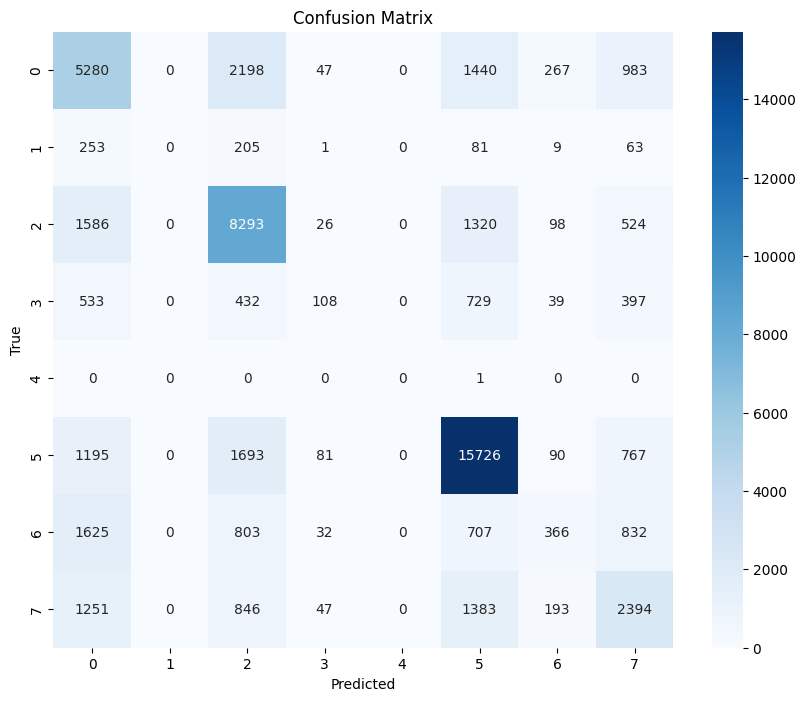

In [10]:
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for sequence, sec_str in test_loader:
        sequence = sequence.to(device).long()
        sec_str = sec_str.to(device).long()

        outputs = model(sequence)
        pred = outputs.argmax(dim=-1)

        mask = (sec_str != PAD_IDX) #ignore padded elements

        for i in range(sequence.size(0)):
            seq_mask = mask[i]
            seq_preds = pred[i][seq_mask].cpu().numpy()
            seq_targets = sec_str[i][seq_mask].cpu().numpy()

            all_preds.append(seq_preds)
            all_targets.append(seq_targets)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#flatten lists
flat_preds = np.concatenate(all_preds)
flat_targets = np.concatenate(all_targets)

accuracy = accuracy_score(flat_targets, flat_preds)
report = classification_report(flat_targets, flat_preds, target_names=secstr_labels, zero_division=0)
conf_matrix = confusion_matrix(flat_targets, flat_preds)

print(f"Test Accuracy: {accuracy*100:.2f}%")
print("Classification Report:")
print(report)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')